In [3]:
import pandas as pd
import analysis
from vega import VegaLite
import numpy as np
nan = np.nan
from scipy.stats import pearsonr, describe, f_oneway
import seaborn as sns
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Evaluation

This notebooks contains the full statistical evaluation of the passively collected data and the coded answers.

## Load data

In [4]:
study = pd.read_pickle("outputs/201907121200_transitions.pkl", compression="gzip")
study.query("duration > 10").query("viewing.isna() == True")

Empty DataFrame
Columns: [time, source, user, session, userAgent, screenWidth, screenHeight, windowWidth, windowHeight, resolution, chart, relativePosition, absolutePosition, message, story, substory, layout, transition, condition, duration, viewing, typing, inactive, WorkerId, code, has_finished, transitionCount, session_start, relative_time]
Index: []

[0 rows x 29 columns]

In [5]:
slow_sessions = pd.read_pickle("outputs/201907121600_slow_sessions.pkl", compression="gzip")

## Load coded data

In [6]:
relationship = (pd.read_csv("inputs/coded/20190730-pilot3-answers - Jonas.csv", na_values="na")
    .query("coder == 'Jonas'")
    .query("(chart == '@answer: Qrelationship')")
    .filter(["session", "first chart", "second chart", "relationship?", "correct relationship?", "causal?", "#groups?"])
    .rename({
        "first chart": "first_chart",
        "second chart": "second_chart",
        "relationship?": "relationship",
        "correct relationship?": "correct_relationship",
        "causal?": "causal_relationship",
        "#groups?": "groups",
    }, axis=1)
)
relationship.head()

session  first_chart  second_chart  relationship  \
106  1562866829595-0.wmvfp1tqbhm          NaN           NaN           0.0   
107  1562867759746-0.r5ntzznep5c          NaN           NaN           1.0   
108  1562871905200-0.wahbqq8v2oa          0.0           1.0           0.0   
109   1562873079603-0.wglqvsp2uj          NaN           NaN           1.0   
110  1562874210221-0.d5m49f3pzsk          0.0           1.0           0.0   

     correct_relationship  causal_relationship  groups  
106                   0.0                  0.0     2.0  
107                   1.0                  1.0     2.0  
108                   0.0                  0.0     0.0  
109                   0.0                  0.0     5.0  
110                   0.0                  0.0     4.0

In [7]:
secondConclusion = (pd.read_csv("inputs/coded/20190730-pilot3-answers - Jonas.csv", na_values="na")
    .query("coder == 'Jonas'")
    .query("(chart == '@answer: QsecondConclusion')")
    .filter(["session", "correct?", "relationship?", "correct relationship?", "implicit relationship"])
    .rename({
        "correct?": "correct",
        "relationship?": "relationship",
        "correct relationship?": "correct_relationship",
        "implicit relationship": "implicit",
    }, axis=1)
)
secondConclusion.head()

session  correct  relationship  correct_relationship  \
214  1562866829595-0.wmvfp1tqbhm      1.0           0.0                   0.0   
215  1562867759746-0.r5ntzznep5c      1.0           0.0                   0.0   
216  1562871905200-0.wahbqq8v2oa      0.0           0.0                   0.0   
217   1562873079603-0.wglqvsp2uj      1.0           0.0                   0.0   
218  1562874210221-0.d5m49f3pzsk      1.0           0.0                   0.0   

     implicit  
214       0.0  
215       0.0  
216       0.0  
217       0.0  
218       1.0

## Combine the coding of the two questions

In [8]:
combined = pd.merge(relationship, secondConclusion, on="session")

combined["relationship"] = combined["relationship_x"]
combined.loc[combined.relationship_y == 1 ,"relationship"] = 1 

combined["correct_relationship"] = combined["correct_relationship_x"]
combined.loc[combined.correct_relationship_y == 1 ,"correct_relationship"] = 1 

combined = combined.drop([
    "relationship_x", "relationship_y", 
    "correct_relationship_x", "correct_relationship_y",
    "implicit", "correct"
], axis=1)


print("Relationship:")
print(relationship.query("relationship == 1").shape[0])
print(combined.query("relationship == 1").shape[0])

print("------------------")
print("Correct relationship:")
print(relationship.query("correct_relationship == 1").shape[0])
print(combined.query("correct_relationship == 1").shape[0])


Relationship:
152
162
------------------
Correct relationship:
97
102


## Merge with the collected data

In [9]:
result = (study
 .groupby("session")
 .agg({
     'user': 'first',
     'time': 'first',
     'duration': 'first',
     'viewing': 'mean',
     'typing': 'mean',
     'inactive': 'mean',
     'layout': 'first',
     'transition': 'first',
     'story': 'first',
     'substory': 'first',
     'condition': 'first',
     'WorkerId': 'first',
     'transitionCount': 'first',
     "message": lambda x: len(x.str.split(" "))
 })
 .query("WorkerId.isnull() == False")
 .query("story != 'envelope'")
 .rename({
     'duration': 'total_duration',
     'viewing': 'viewing_duration',
     'typing': 'typing_duration',
     'inactive': 'inactive_duration',
     'message': 'word_count',
     'transitionCount': 'transition_count',
     'WorkerId': "MTurkID",
     'time': 'starting_time'
 }, axis=1)
 .reset_index()
)
result.columns

Index(['session', 'user', 'starting_time', 'total_duration',
       'viewing_duration', 'typing_duration', 'inactive_duration', 'layout',
       'transition', 'story', 'substory', 'condition', 'MTurkID',
       'transition_count', 'word_count'],
      dtype='object')

In [10]:
age = (pd.read_csv("inputs/coded/20190730-pilot3-answers - Jonas.csv", na_values="na")
    .query("chart == '@answer: age'")
    .filter(["user", "age"])
)

colorblind = (pd.read_csv("inputs/coded/20190730-pilot3-answers - Jonas.csv", na_values="na")
    .query("chart == '@answer: color'")
    .filter(["user", "correct?"])
    .rename({"correct?": "colorblind"}, axis=1)
    .replace({0:1, 1:0})
)

gender = (study
          .query("chart == '@answer: gender'")
          .filter(["user", "message"])
          .rename({"message": "gender"}, axis=1)
)

level_of_education = (study
                        .query("chart == '@answer: education'")
                        .filter(['user', 'message'])
                        .rename({"message": "education"}, axis=1)

                     )

sight = (study
            .query("chart == '@answer: sight'")
            .filter(['user', 'message'])
            .rename({"message": "sight"}, axis=1)
         )

engagement = (study
           .query("chart.str.contains('@answer: QFAS')")
            .filter(["session", "message"])
            .replace({
                "Strongly disagree": 1,
                "Disagree": 2,
                "Neither agree nor disagree": 3,
                "Agree": 4,
                "Strongly agree": 5
            })
            .rename({"message": "engagement"}, axis=1)
            .groupby("session")
            .agg({"engagement": "mean"})
       )

In [11]:
coded = pd.merge(result, combined, on="session")
coded = pd.merge(coded, age, on="user", how="left")
coded = pd.merge(coded, colorblind, on="user", how="left")
coded = pd.merge(coded, gender, on="user", how="left")
coded = pd.merge(coded, level_of_education, on="user", how="left")
coded = pd.merge(coded, sight, on="user", how="left")
coded = pd.merge(coded, engagement, on="session", how="left")
coded.loc[coded.session.isin(slow_sessions.session), "slow"] = 1
coded.loc[coded.slow != 1, "slow"] = 0
coded.drop_duplicates(inplace=True)
coded.head()

session                         user  \
0    1562866062785-0.outi6182ob   1562865729192-0.a9jx3nl92o   
1   1562866379229-0.sztrvwiehtj  1562866268045-0.va714vpqpoh   
2   1562866427714-0.rqm1o2tz6ob   1562865729192-0.a9jx3nl92o   
3  1562866479390-0.0x6bwnwfn38e  1562866268045-0.va714vpqpoh   
4    1562866592864-0.g5lh65z7zk  1562866268045-0.va714vpqpoh   

            starting_time  total_duration  viewing_duration  typing_duration  \
0 2019-07-11 17:27:42.785         363.091           105.829          210.021   
1 2019-07-11 17:32:59.229          97.167            89.626           47.961   
2 2019-07-11 17:33:47.714         230.625           116.796          127.929   
3 2019-07-11 17:34:39.390         111.171           106.965           56.716   
4 2019-07-11 17:36:32.864          62.204            61.463           31.386   

   inactive_duration      layout transition      story  ... groups  \
0            102.341  superposed     static  mortality  ...    2.0   
1                NaN  superposed     static  mortality  ...    0.0   
2                NaN  superposed     static  mortality  ...    2.0   
3                NaN  superposed     static  mortality  ...    0.0   
4                NaN  superposed     static  mortality  ...    NaN   

  relationship correct_relationship   age  colorblind  gender  \
0          1.0                  1.0  26.0         0.0    Male   
1          0.0                  0.0  48.0         0.0    Male   
2          0.0                  0.0  26.0         0.0    Male   
3          0.0                  0.0  48.0         0.0    Male   
4          NaN                  NaN  48.0         0.0    Male   

                         education                 sight  engagement  slow  
0  Bachelor's degree or equivalent  I have normal vision    2.000000   0.0  
1  Bachelor's degree or equivalent  I have normal vision    2.333333   0.0  
2  Bachelor's degree or equivalent  I have normal vision    2.000000   0.0  
3  Bachelor's degree or equivalent  I have normal vision    3.000000   0.0  
4  Bachelor's degree or equivalent  I have normal vision    3.000000   0.0  

[5 rows x 28 columns]

In [12]:
coded.loc[coded.inactive_duration.isna(), "inactive_duration"] = 0

In [13]:
coded.loc[coded.education == "Primary education", "education"] = 0
coded.loc[coded.education == "High school or equivalent", "education"] = 1
coded.loc[coded.education == "Professional education, associates degree or equivalent", "education"] = 2
coded.loc[coded.education == "Bachelor's degree or equivalent", "education"] = 3
coded.loc[coded.education == "Master's degree, equivalent or higher", "education"] = 4

In [14]:
coded.loc[coded.sight == "I don't have normal vision", "sight"] = 0
coded.loc[coded.sight == "I wear glasses/contact lenses to have corrected to normal vision right now", "sight"] = 1
coded.loc[coded.sight == "I have normal vision", "sight"] = 2

### Merge with tones

In [15]:
tones = (pd.read_pickle("outputs/20190822_tones.pkl", compression="gzip")
         .filter(["session", "analytical", "confident", "joy", "tentative", "fear", "sadness"]))
tones.head()

session  analytical  confident       joy  tentative  \
106  1562866829595-0.wmvfp1tqbhm    0.848844        NaN       NaN        NaN   
107  1562867759746-0.r5ntzznep5c    0.803411   0.705889       NaN        NaN   
108  1562871905200-0.wahbqq8v2oa    0.663686        NaN  0.560805        NaN   
109   1562873079603-0.wglqvsp2uj    0.899793        NaN       NaN   0.899444   
110  1562874210221-0.d5m49f3pzsk    0.919706        NaN       NaN   0.616216   

     fear  sadness  
106   NaN      NaN  
107   NaN      NaN  
108   NaN      NaN  
109   NaN      NaN  
110   NaN      NaN

In [16]:
coded = pd.merge(coded, tones, on="session", how="left")
coded.head()

session                         user  \
0    1562866062785-0.outi6182ob   1562865729192-0.a9jx3nl92o   
1   1562866379229-0.sztrvwiehtj  1562866268045-0.va714vpqpoh   
2   1562866427714-0.rqm1o2tz6ob   1562865729192-0.a9jx3nl92o   
3  1562866479390-0.0x6bwnwfn38e  1562866268045-0.va714vpqpoh   
4    1562866592864-0.g5lh65z7zk  1562866268045-0.va714vpqpoh   

            starting_time  total_duration  viewing_duration  typing_duration  \
0 2019-07-11 17:27:42.785         363.091           105.829          210.021   
1 2019-07-11 17:32:59.229          97.167            89.626           47.961   
2 2019-07-11 17:33:47.714         230.625           116.796          127.929   
3 2019-07-11 17:34:39.390         111.171           106.965           56.716   
4 2019-07-11 17:36:32.864          62.204            61.463           31.386   

   inactive_duration      layout transition      story  ... education sight  \
0            102.341  superposed     static  mortality  ...         3     2   
1              0.000  superposed     static  mortality  ...         3     2   
2              0.000  superposed     static  mortality  ...         3     2   
3              0.000  superposed     static  mortality  ...         3     2   
4              0.000  superposed     static  mortality  ...         3     2   

  engagement  slow  analytical  confident  joy  tentative  fear  sadness  
0   2.000000   0.0    0.505877        NaN  NaN        NaN   NaN      NaN  
1   2.333333   0.0         NaN        NaN  NaN        NaN   NaN      NaN  
2   2.000000   0.0         NaN    0.91171  NaN        NaN   NaN      NaN  
3   3.000000   0.0         NaN        NaN  NaN        NaN   NaN      NaN  
4   3.000000   0.0         NaN        NaN  NaN        NaN   NaN      NaN  

[5 rows x 34 columns]

In [17]:
for tone in ["analytical", "tentative", "confident", "fear", "joy", "sadness"]:
    print(tone, coded[tone].mean())

analytical 0.7860817491525424
tentative 0.7889899171974523
confident 0.7848673387096774
fear 0.6017594285714285
joy 0.6027370508474577
sadness 0.6558000476190475


In [18]:
for tone in ["analytical", "tentative", "confident", "fear", "joy", "sadness"]:
    print(tone, coded.query(tone+".isna() == False").shape[0])

analytical 295
tentative 157
confident 62
fear 7
joy 59
sadness 126


In [19]:
coded.shape

(426, 34)

## Export the results

In [20]:
coded.to_csv("outputs/201907231200_coded.csv",header=True)
coded.to_pickle("outputs/201907231200_coded.pkl", compression="gzip")

## Proportion of valid answers

In [21]:
1-len(coded
    .query("relationship.isna()")
    .query("substory != 0")
) / len(coded)

0.9389671361502347

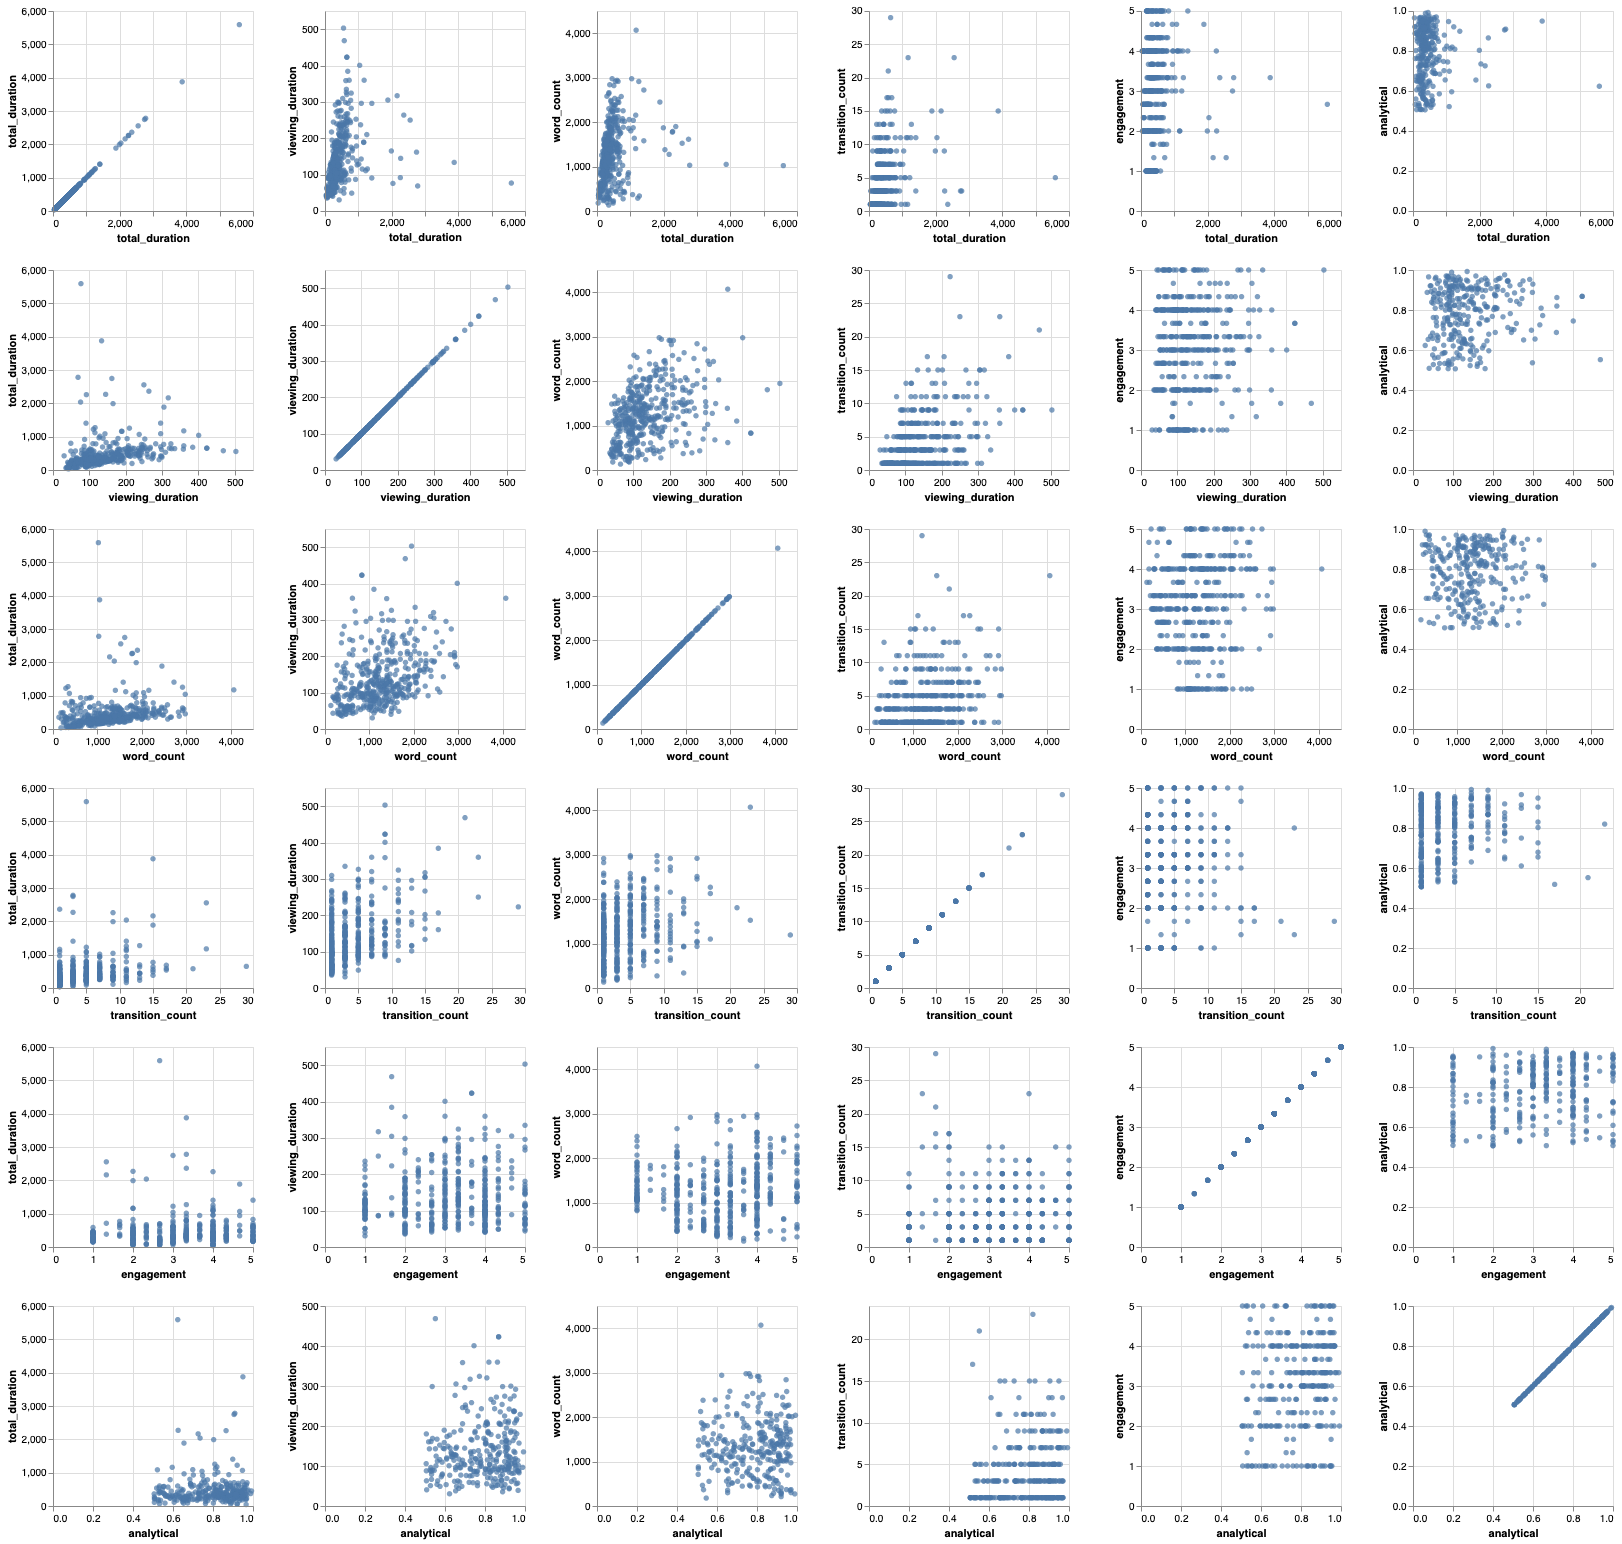

In [22]:
VegaLite({ 
    "repeat": {
        "row": ["total_duration", "viewing_duration", "word_count", "transition_count", "engagement", "analytical"],
        "column": ["total_duration", "viewing_duration", "word_count", "transition_count", "engagement", "analytical"],
    },
    "spec": {
          "mark": "circle",
    "encoding": {
        "x": {"field": {"repeat": "row"}, "type": "quantitative"},
        "y": {"field": {"repeat": "column"}, "type": "quantitative"},
        "tooltip": {"field": "substory", "type": "nominal"}
    },  
    }

}, coded)

Much stronger correlation between transition count and viewing duration than between transition count and total duration. Makes sense but shows that viewing duration is more or less properly calculated.

In [23]:
print(coded.transition_count.corr(coded.viewing_duration, method="spearman"))
print(coded.transition_count.corr(coded.total_duration, method="spearman"))

0.4718107647732309
0.4424613622415462


No correlation between transition count and engagement

In [24]:
coded.transition_count.corr(coded.engagement, method="spearman")

0.04639421887227942

The correlation between word count and engagement is very weak and probably negligble

In [25]:
coded.word_count.corr(coded.engagement, method="spearman")

0.10152755702351152

## How easy are the stories?

In [26]:
byStories = coded.groupby(["story", "substory"]).agg({
    "relationship": "mean", 
    "correct_relationship": "mean",
    "causal_relationship": "mean",
    "typing_duration": "mean",
    "transition_count": "mean",
    "viewing_duration": "mean",
    "word_count": "mean",
    "engagement": "mean",
    "groups": "mean",
    "session": "count",
    "analytical": "mean",
    "confident": "mean",
    "tentative": "mean"
}).rename({"session": "count"})
byStories.transpose()

story                      energy                                         \
substory                        1            2            3            4   
relationship             0.358491     0.420000     0.333333     0.617021   
correct_relationship     0.188679     0.240000     0.187500     0.468085   
causal_relationship      0.037736     0.080000     0.062500     0.425532   
typing_duration        208.928296   200.000870   179.229245   178.740660   
transition_count         4.074074     4.222222     3.377358     4.433962   
viewing_duration       164.445685   146.216074   123.824075   135.327623   
word_count            1406.351852  1321.796296  1202.603774  1244.000000   
engagement               2.901235     3.000000     3.132075     3.012579   
groups                   2.320000     1.740000     3.282609     2.340426   
session                 54.000000    54.000000    53.000000    53.000000   
analytical               0.840217     0.798952     0.791603     0.802906   
confident                0.714225     0.826743     0.850925     0.817606   
tentative                0.783481     0.823443     0.796620     0.797789   

story                   mortality                                         
substory                        1            2            3            4  
relationship             0.509804     0.360000     0.180000     0.470588  
correct_relationship     0.333333     0.140000     0.120000     0.372549  
causal_relationship      0.420000     0.020000     0.000000     0.313725  
typing_duration        212.446585   191.367434   217.545226   214.305642  
transition_count         3.716981     4.698113     5.264151     3.641509  
viewing_duration       144.127132   131.765434   131.120623   148.033283  
word_count            1244.226415  1204.905660  1225.698113  1274.660377  
engagement               3.157233     3.106918     3.088050     3.251572  
groups                   1.039216     1.300000     1.140000     1.490196  
session                 53.000000    53.000000    53.000000    53.000000  
analytical               0.762789     0.764104     0.747539     0.765198  
confident                0.770501     0.817300     0.774781     0.746093  
tentative                0.771776     0.800842     0.794589     0.762642

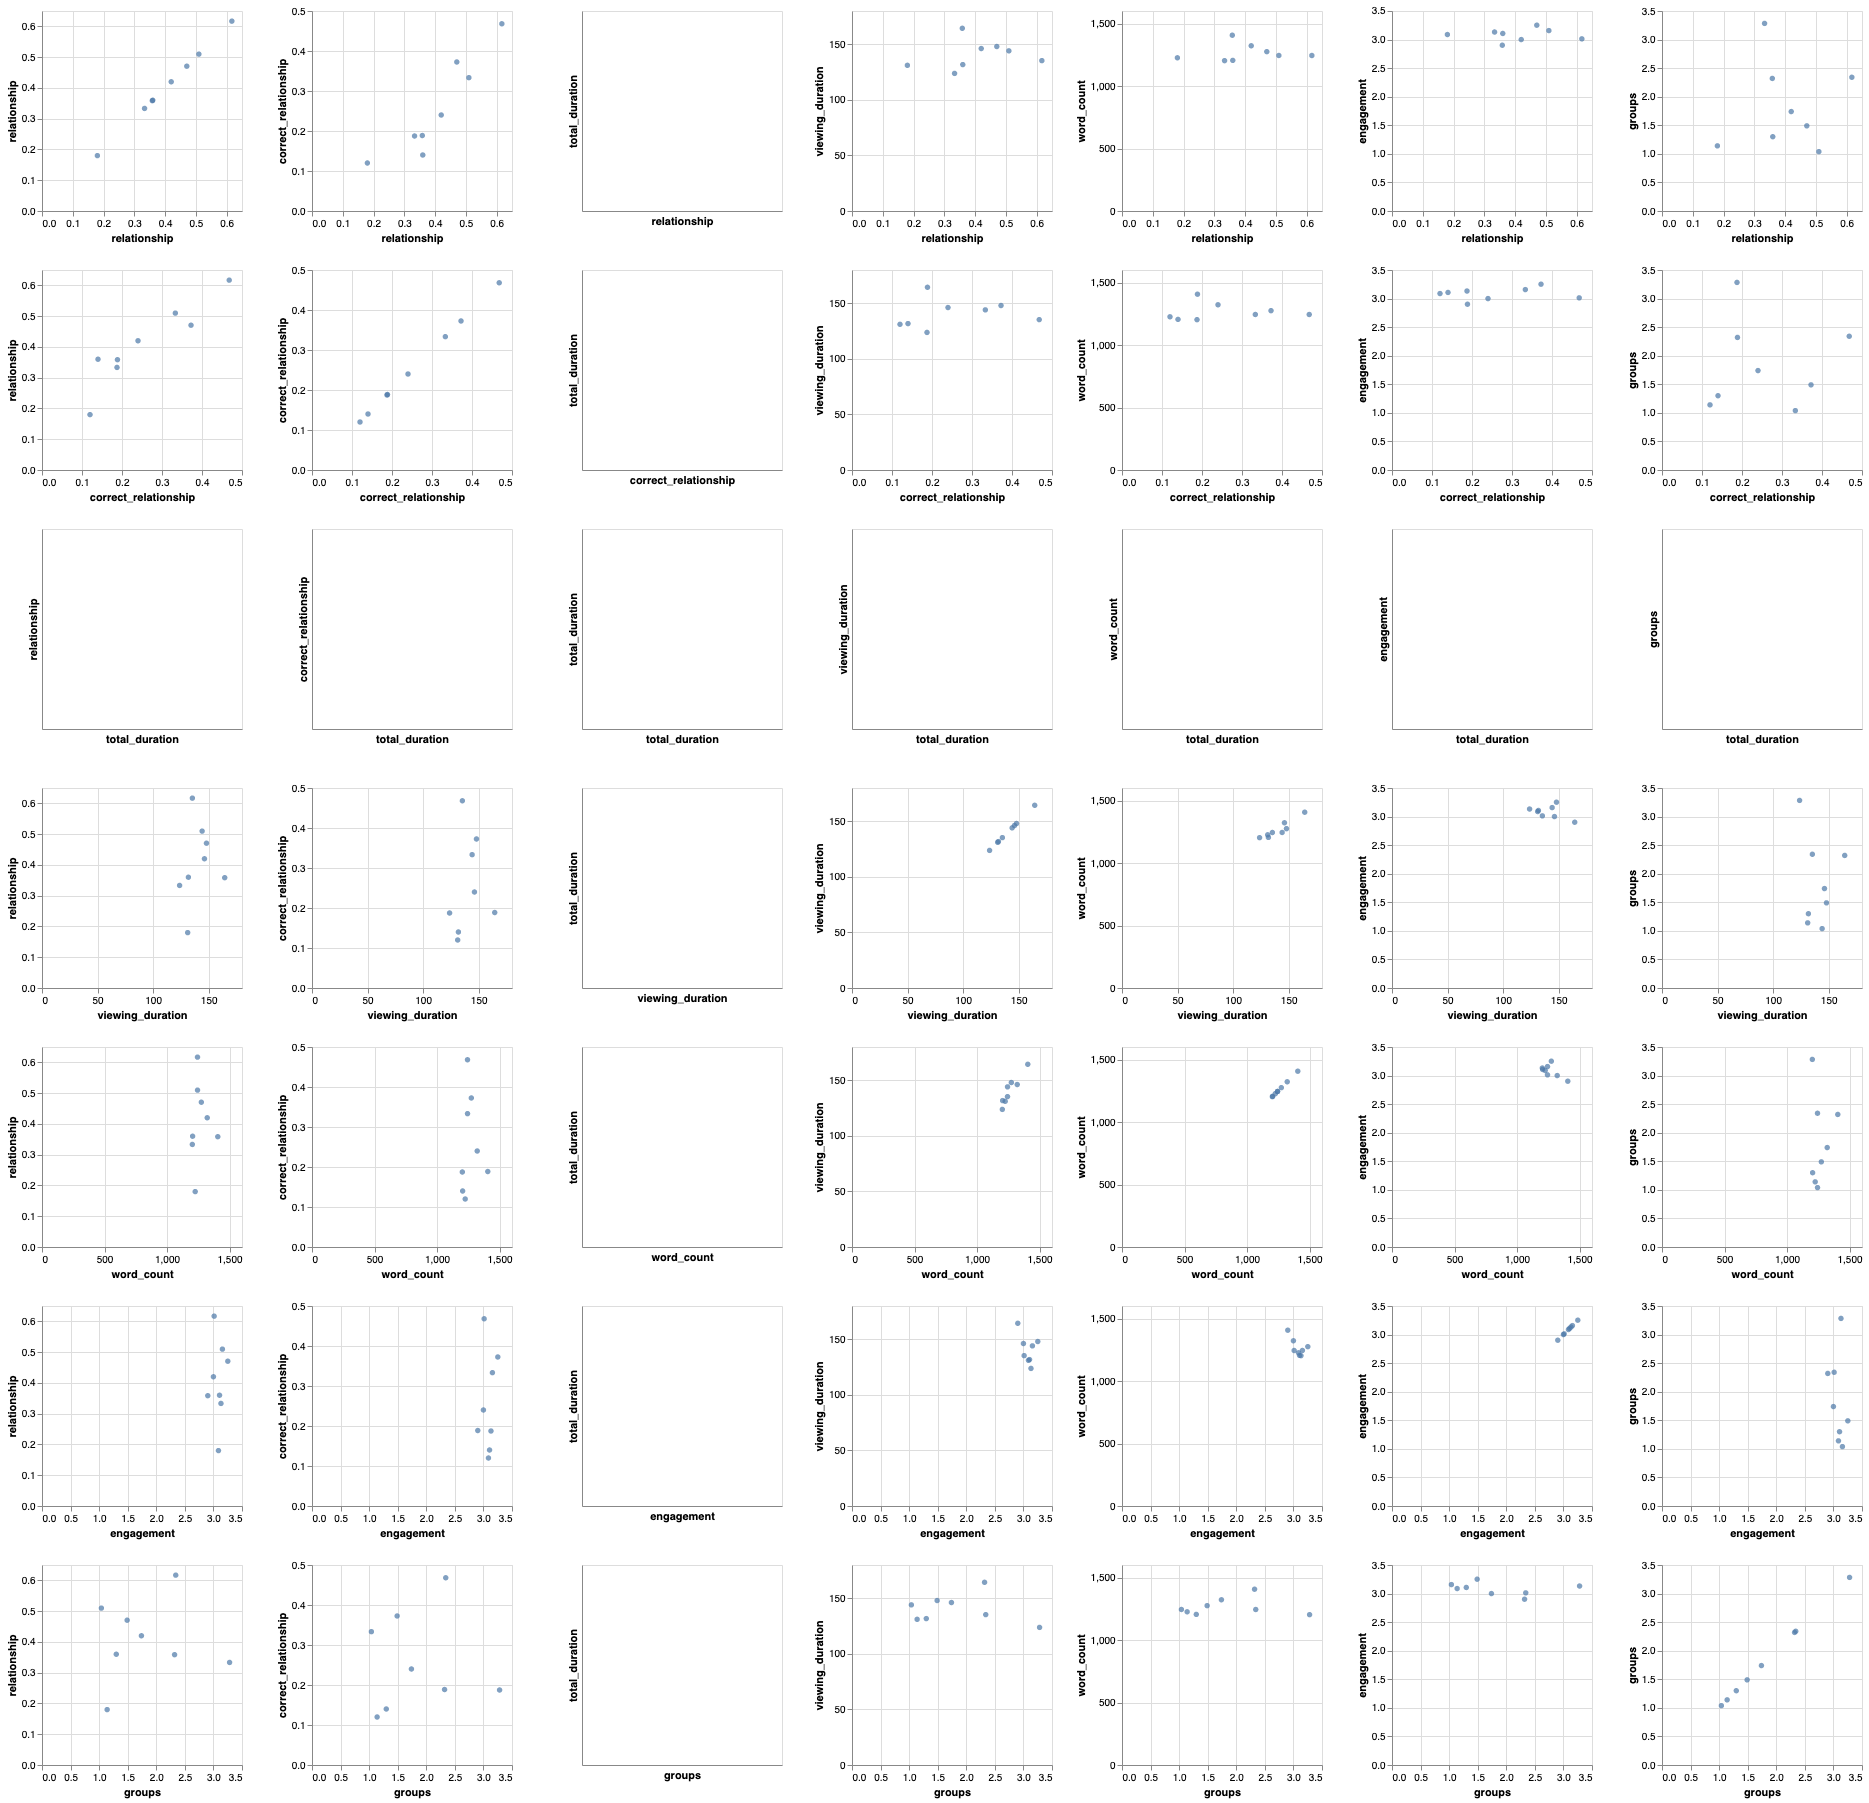

In [28]:
VegaLite({ 
    "repeat": {
        "row": ["relationship", "correct_relationship", "total_duration", "viewing_duration", "word_count", "engagement", "groups"],
        "column": ["relationship", "correct_relationship", "total_duration", "viewing_duration", "word_count", "engagement", "groups"],
    },
    "spec": {
          "mark": "circle",
    "encoding": {
        "x": {"field": {"repeat": "row"}, "type": "quantitative"},
        "y": {"field": {"repeat": "column"}, "type": "quantitative"},
        "tooltip": {"field": "substory", "type": "nominal"}
    },  
    }

}, byStories.reset_index())

## How do the transitions differ?

In [29]:
byTransition = (coded
    .groupby(["transition"])
    .agg({
    "relationship": "mean", 
    "correct_relationship": "mean", 
    "causal_relationship": "mean",
    "groups": "mean",
    "total_duration": "mean",
    "viewing_duration": "mean",
    "transition_count": "mean",
    "word_count": "mean",
    "engagement": "mean",
    "first_chart": "sum",
    "second_chart": "sum",
    "fear": "mean",
    "session": "count"
})
    .assign(skew_to_chart2 = lambda x: x.second_chart / x.first_chart)
    .rename({"session": "count"}, axis=1)
    .drop(["first_chart", "second_chart"], axis=1)
)
byTransition

relationship  correct_relationship  causal_relationship    groups  \
transition                                                                      
animated        0.394089              0.261084             0.138614  1.613861   
static          0.416244              0.248731             0.197970  2.015544   

            total_duration  viewing_duration  transition_count   word_count  \
transition                                                                    
animated        440.855250        144.168316          3.509434  1333.471698   
static          471.768575        137.217547          4.841121  1199.144860   

            engagement      fear  count  skew_to_chart2  
transition                                               
animated      3.114780  0.581428    212        1.765306  
static        3.046729  0.628868    214        1.640777

In [98]:
from scipy.stats import ttest_ind
aa = coded
sa = coded

def ttest(attr):
    animated = (coded
        .query("transition == 'animated'")
        .query("(" + attr + ".isna() == False) & (" + attr + ".isnull() == False)"))
    static = (coded
        .query("transition == 'static'")
        .query("(" + attr + ".isna() == False) & (" + attr + ".isnull() == False)"))
    return  ttest_ind(animated[attr], static[attr], equal_var=True)

def ttest_with_data(attr, data):
    animated = (data
        .query("transition == 'animated'")
        .query("(" + attr + ".isna() == False) & (" + attr + ".isnull() == False)"))
    static = (data
        .query("transition == 'static'")
        .query("(" + attr + ".isna() == False) & (" + attr + ".isnull() == False)"))
    return  ttest_ind(animated[attr], static[attr], equal_var=True)

In [99]:
def draw(attr, title):
    return VegaLite({
  "encoding": {"y": {"field": "transition", "type": "ordinal", "title": "Transition"}},
  "layer": [
    {
      "mark": {"type": "point", "filled": True},
      "encoding": {
        "x": {
          "aggregate": "mean",
          "field": attr,
          "type": "quantitative",
          "title": title 
        },
        "color": {"value": "black"}
      }
    },
    {
      "mark": {"type": "errorbar", "extent": "ci"},
      "encoding": {
        "x": {"field": attr, "type": "quantitative", "title": title}
      }
    }
  ],
      "width": 400
}, coded)

## H1: Correct understanding

In [100]:
ttest("correct_relationship")

Ttest_indResult(statistic=0.2826979984757262, pvalue=0.7775553147535141)

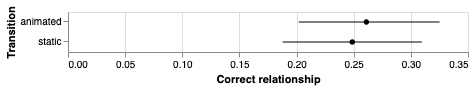

In [101]:
draw("correct_relationship", "Correct relationship")

## H2: Relationship

Clearly not significant

In [102]:
ttest("relationship")

Ttest_indResult(statistic=-0.4502551826678746, pvalue=0.6527716049769717)

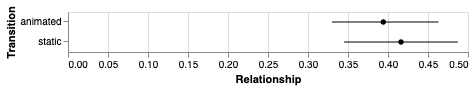

In [103]:
draw("relationship", "Relationship")

## H3: Causality

Almost significant.

In [104]:
ttest("causal_relationship")

Ttest_indResult(statistic=-1.5868389764770374, pvalue=0.11334523912452879)

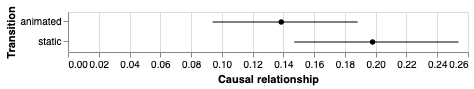

In [105]:
draw("causal_relationship", "Causal relationship")

## H4: Object constancy

Animation seems to help with object constancy. Interestingly, their viewing duration stays the same

In [106]:
ttest("transition_count")

Ttest_indResult(statistic=-3.374650813288365, pvalue=0.0008071156167094947)

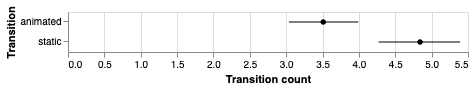

In [107]:
draw("transition_count", "Transition count")

In [108]:
ttest("viewing_duration")

Ttest_indResult(statistic=0.9257476999865706, pvalue=0.35510371308121513)

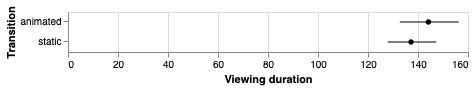

In [109]:
draw("viewing_duration", "Viewing duration")

## H5: Highlighting

Animation clearly focuses readers on the animations but this doesn't lead them to mention more correct relationships

In [110]:
ttest("groups")

Ttest_indResult(statistic=-2.816710302398242, pvalue=0.005096528685145737)

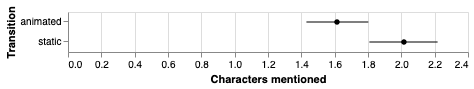

In [111]:
draw("groups", "Characters mentioned")

## H6: Engagement

In [112]:
ttest("engagement")

Ttest_indResult(statistic=0.6119439422166559, pvalue=0.5409028437682445)

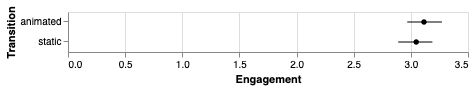

In [113]:
draw("engagement", "Engagement")

In [114]:
ttest("word_count")

Ttest_indResult(statistic=2.2081881147638147, pvalue=0.027765626272284773)

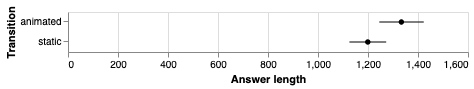

In [115]:
draw("word_count", "Answer length")

In [116]:
ttest("typing_duration")

Ttest_indResult(statistic=-1.069899966782491, pvalue=0.2852730179708756)

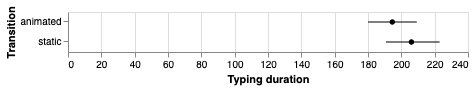

In [117]:
draw("typing_duration", "Typing duration")

In [118]:
ttest("confident")

Ttest_indResult(statistic=-0.025005932018718164, pvalue=0.9801332137878276)

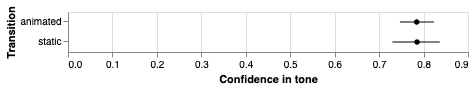

In [119]:
draw("confident", "Confidence in tone")

In [120]:
ttest("tentative")

Ttest_indResult(statistic=-0.23304094622307536, pvalue=0.816037069969864)

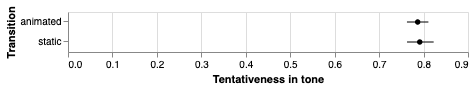

In [121]:
draw("tentative", "Tentativeness in tone")

In [122]:
ttest("analytical")

Ttest_indResult(statistic=-1.0588824551390075, pvalue=0.29052546701718956)

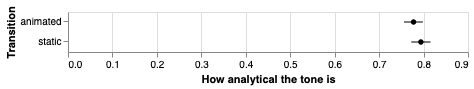

In [123]:
draw("analytical", "How analytical the tone is")

In [124]:
(coded
 .query("((story == 'mortality') & (substory == '1')) |\
 (story == 'mortality') & (substory == '4') |\
 (story == 'energy') & (substory == '2') |\
 (story == 'energy') & (substory == '4')")
 .groupby(["transition"])
    .agg({
    "relationship": "mean", 
    "correct_relationship": "mean", 
    "causal_relationship": "mean",
    "groups": "mean",
    "viewing_duration": "mean",
    "transition_count": "mean",
    "word_count": "mean",
    "engagement": "mean",
    "first_chart": "sum",
    "second_chart": "sum",
})
    .assign(skew_to_chart2 = lambda x: x.second_chart / x.first_chart)
    .drop(["first_chart", "second_chart"], axis=1)
)

relationship  correct_relationship  causal_relationship    groups  \
transition                                                                      
animated        0.460784              0.323529             0.237624  1.490196   
static          0.546392              0.381443             0.381443  1.793814   

            viewing_duration  transition_count   word_count  engagement  \
transition                                                                
animated          148.210915          3.320755  1328.933962    3.125786   
static            138.711935          4.682243  1214.420561    3.084112   

            skew_to_chart2  
transition                  
animated          1.627119  
static            1.343284

In [125]:
(coded
 .query("((story == 'mortality') & (substory == '1')) |\
 (story == 'mortality') & (substory == '4') |\
 (story == 'energy') & (substory == '2') |\
 (story == 'energy') & (substory == '4')")
 .query("slow == 0")
 .groupby(["transition"])
    .agg({
    "relationship": "mean", 
    "correct_relationship": "mean", 
    "causal_relationship": "mean",
    "groups": "mean",
    "viewing_duration": "mean",
    "transition_count": "mean",
    "word_count": "mean",
    "engagement": "mean",
    "first_chart": "sum",
    "second_chart": "sum",
})
    .assign(skew_to_chart2 = lambda x: x.second_chart / x.first_chart)
    .drop(["first_chart", "second_chart"], axis=1)
)

relationship  correct_relationship  causal_relationship    groups  \
transition                                                                      
animated        0.432099              0.308642             0.225000  1.518519   
static          0.546392              0.381443             0.381443  1.793814   

            viewing_duration  transition_count   word_count  engagement  \
transition                                                                
animated          146.707691          3.148148  1473.543210    3.197531   
static            138.711935          4.682243  1214.420561    3.084112   

            skew_to_chart2  
transition                  
animated          1.688889  
static            1.343284